# Fluid Ascent via Europan Ice Shell Dikes
### Fall 2025

### Pressurized Ocean

In [ ]:
# preamble
import os
import sys
import matplotlib.pyplot as plt
import pdb
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
from matplotlib import ticker
import scipy as sp
from scipy.integrate import cumulative_trapezoid, trapezoid, odeint, solve_bvp, solve_ivp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colormaps
import matplotlib.ticker as mtick
from matplotlib.ticker import LogLocator, FuncFormatter, NullFormatter, FixedLocator, StrMethodFormatter, LogFormatter, LogFormatterSciNotation, LogFormatterExponent, LogFormatterMathtext, FixedFormatter
from matplotlib.lines import lineStyles
import cmocean
import cmocean.cm as cmo
from matplotlib.colors import LogNorm
from IPython.display import clear_output
import matplotlib.patheffects as pe
from matplotlib.collections import LineCollection
from labellines import labelLines
def sci_fmt(x):
    if x == 0 or not np.isfinite(x):
        return "0"
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / (10**exp)
    # round mantissa to integer as you requested
    return rf"{mant:.0f}$×10^{{exp}}$"

In [3]:
# constants
beta = 4e-10 # Pa-1, compressibility at ~273.15 K
rhow = 1025 # kg m-3
rhoi = 916 # kg m-3
delta_rho = rhow - rhoi # kg m-3
Cp = 4.2e3 # J kg-1 K
kappa = 1e-6 # thermal diffusivity (m2/s)
λ = 0.65 # thermodynamic parameter of ice (adimensional)
g = 1.315 # m/s2
nu = 0.3 # Poisson's ratio
E = 5e9 # Pa, Young's modulus
G = 3.3e9 # Pa, shear modulus from Berne et al., 2023
m = G / (1 - nu)
eta_w = 1e-3 # Pa s, viscosity of water

# tensile strength
S = 1e6 # Pa, tensile strength of ice
Kc = 1e6 # Pa m1/2, fracture toughness of ice

# depth params
ymi = 1 # m, initial ice shell thickness
R = 1.5608e6 # m, radius of Europa
rc = 1.4608e6 # m, radius to top of silicate component
rii = R - ymi # m, initial radius of ice shell base
ri_timed = np.zeros((1,2)) # m, radii of ice shell base
ri_timed[0,0] = 0
ri_timed[0] = [rii, 0]
dzi = (ymi)/61
dti = 0.1*((0.1*(dzi**2))/kappa)

## time params
y2sec = 3.1536e7 # s/yr
tend = 5e6*y2sec # end time (s)
t = ((ymi/(2*λ))**2)/kappa # starting time (s)
n = 0 # first iteration


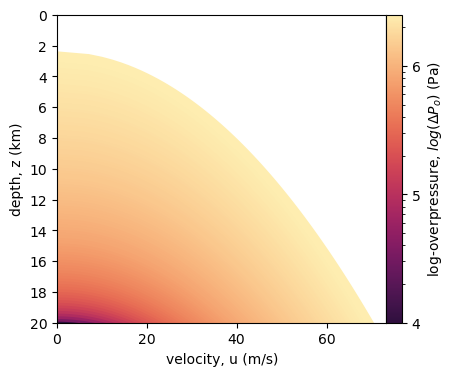

In [4]:
DP = np.linspace(1e4, 2.5e6, 100) # change factors of overpressure
max_depth = 20e3
fig, ax1 = plt.subplots(figsize=(5,4))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
cmap = plt.get_cmap(cmo.matter_r)
DP_norm = LogNorm(vmin=np.min(DP), vmax=np.max(DP))
fig.subplots_adjust(wspace=0.1) # Remove space between plots
velocities = []
os = []
Ws = []

for dp in DP:
    deltarho = delta_rho
    Pgrad = deltarho * g
    LNB = dp / (deltarho * g)
    h_max = np.linspace(0, LNB, 100)
    w = dp * h_max / m  # M&M dike width (Eqn. 4)
    p = dp - deltarho * g * h_max
    p[p < 0] = 0
    # M&M dike velocity (Eqn. 3)
    u = np.sqrt(2 * p / rhow) # M&M dike velocity (Eqn. 3)
    # L&K turbulent dike velocity (Eqn. 8b)
    # u_turb = 7.7*((w**5) / (eta_w * rhow**3 * (np.abs(Pgrad))**3))**(1/7) * np.abs(Pgrad)
    z = max_depth - h_max
    overshoot = (m * w / (deltarho * g))**(1/2)
    z_os = z - overshoot
    u[p == 0] = 0
    # q = u * w * LNB # for a dike of breath approximated by its height
    ax1.plot(u, z/1e3, color=cmap(DP_norm(dp)), linewidth=4)
    # ax1.plot(u, z_os/1e3, color='black', linewidth=4)
    velocities.append(u)
    os.append(overshoot)
    Ws.append(w)
    # ax2.plot(w, z/1e3, q / 1e3, color= 'black')

velocities = np.array(velocities)

ax1.set_xlabel('velocity, u (m/s)')
ax1.set_ylabel('depth, z (km)')
ax1.invert_yaxis()
ax1.set_xlim(left=0)
ax1.set_ylim(bottom=20, top=0)
# ax1.set_yticks(np.arange(0, 20, 4))  # ticks at every km
ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# ax2.set_xlabel('width, w (m)')
# ax2.set_ylabel('volumetric flux, Q (km$^3$/s)')
# ax2.set_xlim(left=0)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=DP_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1, pad = 0)
ticks = [1e4, 1e5, 1e6]
tick_labels = [r'4', r'5', r'6']
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
cbar.set_label('log-overpressure, $log(\Delta P_o)$ (Pa)')


/var/folders/4y/tw1pwdb527z5vwkr7_zjbgvw0000gn/T/ipykernel_38476/844193401.py:20: UserWarning: The following kwargs were not used by contour: 'label'
  cont = ax.contour(u_w, w_u, logRe, levels=[6], colors='black', linewidths=1, linestyles='dashed', label='log($R_e$) = 6')


(0.0, 70.01913944132158)

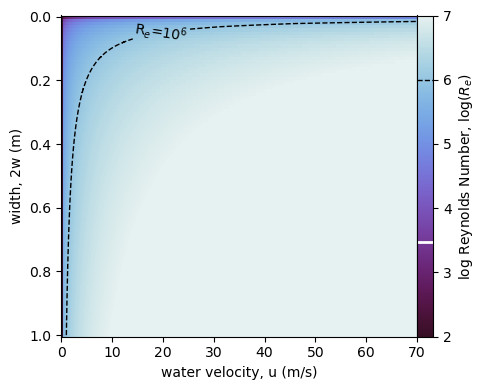

In [5]:
# Reynolds number for different dike geometries and velocities
# Re = ρuL/η
from labellines import labelLines

fig, ax = plt.subplots(layout='tight', figsize=(5,4))

ws = np.linspace(1e-3, 1, 100) # m, half-widths
u = velocities.flatten() # m/s, velocities
u = u[np.isfinite(u)]
u = u[u > 0]
u = np.sort(u)
u_w, w_u = np.meshgrid(u, ws)

Res = (rhow * u_w * w_u) / eta_w
Res[Res <= 0] = np.nan
logRe = np.log10(Res)

pcm = ax.pcolormesh(u_w, w_u, logRe, shading='auto', vmax=7, vmin=2, cmap=cmo.dense_r)
# plt.contour(u_w, w_u, logRe, levels=[3], colors='white', linewidths=0.8)
cont = ax.contour(u_w, w_u, logRe, levels=[6], colors='black', linewidths=1, linestyles='dashed', label='log($R_e$) = 6')
ax.clabel(cont, fmt={6: r'R$_e$=10$^6$'}, inline=True, manual=[(20, 0.1)])
bar = fig.colorbar(pcm, label='log Reynolds Number, log($R_e$)', pad = 0)
bar.ax.hlines(3.48, *bar.ax.get_xlim(), colors='white', linewidth=2, linestyle='solid')
bar.ax.hlines(6, *bar.ax.get_xlim(), colors='black', linewidth=1, linestyle='dashed')
ax.invert_yaxis()
ax.set_xlabel('water velocity, u (m/s)')
ax.set_ylabel('width, 2w (m)')
ax.set_xlim(left=0)

<a list of 4 text.Text objects>

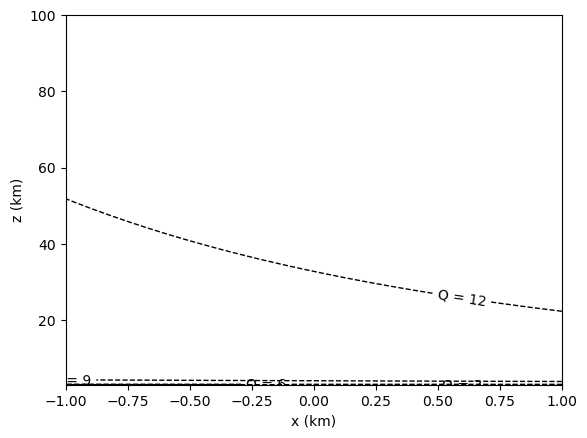

In [9]:
# Lateral Q gradients (W, adimensional width)
# NOTE: Attempt to depict lateral variation in Q [needs work]

max_depth = 100e3
z = np.logspace(np.log10(3000), np.log10(max_depth), 100)  # meters, log-spaced
w = np.linspace(0.005, 5, 100) 
W, Z = np.meshgrid(w, z)

# Lister and Kerr (1991)
q1 = ((2 * W)/ (0.904))**10
q2 = (((-delta_rho) * g)**2 * Z * m) / (eta_w**3)
Q_grid = (q1 * q2)**(1/3)
logQ = np.log10(Q_grid)
Q_m3 = Q_grid
Q_km3 = Q_m3/1e9 # km3/s
x_sample = 1e3
z = np.logspace(np.log10(3000), np.log10(max_depth), 100)
# x = np.linspace(-np.log10(x_sample), np.log10(x_sample), 100)
x = np.linspace(-x_sample, x_sample, 100) 
Z, X = np.meshgrid(z, x)
ksi = 0.381 * X * ( (-delta_rho * g)**4  / (Q_m3 * eta_w * m**3 * Z**3) )**(1/10)
W = (1 - ksi**2)**(3/2)
w = 0.904 * ( Q_m3**3 * eta_w**3 / ( (-delta_rho * g)**2 * Z * m) )**(1/10) * W
Q = ( (w / (0.904 * W) )**10 * ( (-delta_rho * g)**2 * Z * m) / (eta_w**3) )**(1/3)
logQ_36 = np.log10(Q)

contour = plt.contour(X/1e3, Z/1e3, logQ_36, levels=3, colors='black', linewidths=1, linestyles='dashed')
plt.xlabel('x (km)')
plt.ylabel('z (km)')
ax.clabel(contour, inline=True, fontsize=10, fmt='Q = %.0f')

### Eq. 47
$\alpha H^3 - \frac{5\alpha -3}{11}(ξH^3)^{\prime} = (H^7 H^{\prime})^{\prime}$, where $H(1)=0$ or $\lim_{ξ\rightarrow 1}H(ξ) = 0$

$ k=\frac{5\alpha -3}{11}$

$
\alpha H^{3} - \frac{5 \alpha + 3}{11} \left( \xi H^{3} \right)' = \left( H^{7} H' \right)'
$

$\alpha H^3 - k(ξH^3)^{\prime} = (H^7 H^{\prime})^{\prime}$

product rule: $(ξH^3)^{\prime}=\left( H^{3} + 3 \xi H^{2} H' \right)$ and 
$(H^7 H^{\prime})^{\prime}=7 H^{6} (H')^{2} + H^{7} H''$

$\alpha H^{3} - k\left( H^{3} + 3 \xi H^{2} H' \right) = 7 H^{6} (H')^{2} + H^{7} H''$

$\alpha H^{3} - kH^{3} + 3k\xi H^{2} H'= 7 H^{6} (H')^{2} + H^{7} H''$

$H^{7} H''=\alpha H^{3} - kH^{3} + 3k\xi H^{2} H'-7 H^{6} (H')^{2}$

$H''=\frac{\alpha H^{3} - kH^{3} + 3k\xi H^{2} H'-7 H^{6} (H')^{2}}{H^7}$

$H''=\frac{\alpha H^{3}}{H^7} - \frac{kH^{3}}{H^7} + \frac{3k\xi H^{2} H'}{H^7}-\frac{7 H^{6} (H')^{2}}{H^7}$

$H''=\frac{\alpha - k}{H^4} + \frac{3k\xi H'}{H^5}-\frac{7 (H')^{2}}{H}$

rewriting as first-order

$H=y[0]$ and $H'=y[1]$

$y[1]'=\frac{\alpha - k}{y[0]^4} + \frac{3k\xi y[1]}{y[0]^5}-\frac{7 (y[1])^{2}}{y[0]}$




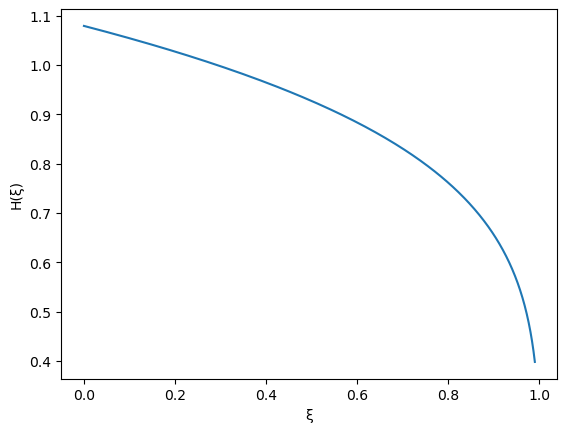

In [10]:
guess = 1e-2
A = 1
xi0 = 1 - guess
xi_left = 0
H0   = A * guess**0.2
Hp0  = - (A / 5) * guess**(-0.8)
alpha = 0
k = (5.0*alpha - 3)/11

def rhs(xi, y):
    H, Hp = y
    y0 = max(H, 1e-16)   # avoid division-by-zero
    dHp = (alpha - k) / (y0**4) + (3.0 * k * xi * Hp) / (y0**5) - 7.0 * (Hp**2) / y0
    return [Hp, dHp]

sol = solve_ivp(rhs, (xi0, xi_left), [H0, Hp0], method='Radau',rtol=1e-8, atol=1e-10, max_step=0.01)

xi = sol.t[::-1]
H = sol.y[0, ::-1]
plt.plot(xi, H)
plt.xlabel('ξ'); plt.ylabel('H(ξ)'); plt.show()


In [11]:
# gamma function
from scipy.special import gamma
a_Lister = 12/7
G_up = gamma(3*a_Lister+2)
G_low = gamma(1/2*(3*a_Lister + 2))**2
print(f'G_up = {G_up:.4f}, \nG_low = {G_low:.4f}')
bN = 1/2 * (6*(3*a_Lister+1)/a_Lister)**(a_Lister/(3*a_Lister + 1)) * (G_up / G_low)**(1/(3*a_Lister + 1))
print(f'bN = {bN:.4f}')
A = 15.4 * eta_w**(-1/7) * (rhow * delta_rho * g)**(-3/7)
print(f'A = {A:.4e}')

G_up = 942.3223, 
G_low = 12.9515
bN = 2.3654
A = 2.5213e-01


(3, 100)

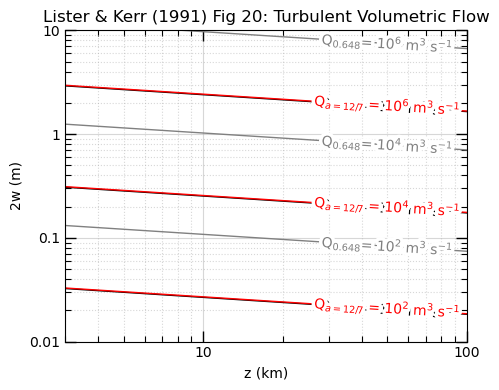

In [12]:
### Fig 20 from Lister & Kerr (1991) 

z = np.linspace(3e3, 100e3, 100)  # meters, log-spaced

fig, ax = plt.subplots(layout='tight', figsize=(5,4))
for a in [2, 4, 6]:
    Q = 10**a
    # x = 0 # at the center of the breadth
    # xi = 0.66 * x * ((g * delta_rho)**16 / (Q**7 * eta * rhom**3 * (m * Z)**12))**(1/43) # ~0
    # w_big = (1 - xi**2)**(3/2)
    w_big = 1 # at x=0
    # Eq 58
    w_648 = 0.648 * ( (Q**21 * eta_w**3 * rhow**9) / (m**7 * (g * delta_rho)**5 * z**7) )**(1/43) * w_big
    w = 0.16 * ( (Q**21 * eta_w**3 * rhow**9) / (m**7 * (g * delta_rho)**5 * z**7) )**(1/43) * w_big
    wLister = a_Lister * bN**3 / (6 * (3*a_Lister+1)) * (Q**3 / (A**3 * (g*delta_rho)**2 * m * z))**(1/(3*a_Lister + 1))
    e = np.log10(Q)
    ls = 'solid'
    # black: manual approx
    ax.plot(z/1e3, 2*w, color='black', linewidth=1, linestyle=ls,
            label=rf'Q$_{{{0.125}}}$ = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
    # red: Lister 1990
    ax.plot(z/1e3, 2*wLister, color='red', linewidth=1, linestyle=ls,
            label=rf'Q$_{{a=12/7}}$ = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
    # gray: Lister & Kerr (1991) (0.648 is probably a typo)
    ax.plot(z/1e3, 2*w_648, color='gray', linewidth=1, linestyle='solid', label=rf'Q$_{{{0.648}}}$= 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$' )

   
labelLines(ax.get_lines(), xvals=[50, 50, 50, 50, 50, 50, 50, 50, 50], align=True, fontsize=10)
ax.set_ylabel('2w (m)')
ax.set_xlabel('z (km)')
ax.loglog()
ax.set_xlabel('z (km)')
ax.set_ylabel('2w (m)')
ax.set_axisbelow(True) # this puts gridlines behind contours
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.xaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1, direction='in', top=True, right=True)
ax.tick_params(which='minor', length=4, width=0.8, direction='in', top=True, right=True)
ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.5, linestyle=':')
ax.set_title('Lister & Kerr (1991) Fig 20: Turbulent Volumetric Flow')
ax.set_ylim(0.01, 10)
ax.set_xlim(3, 100)

(3.0, 30.0)

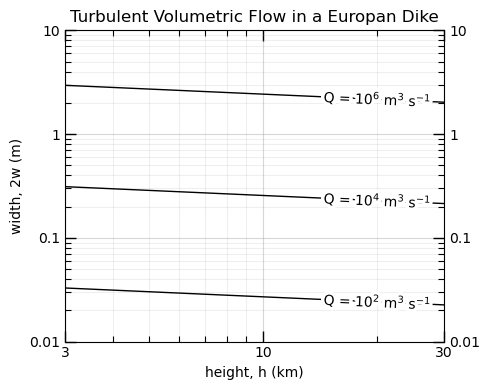

In [14]:
z = np.linspace(3e3, 100e3, 100)  # meters, log-spaced
a_Lister = 12/7
G_up = gamma(3*a_Lister+2)
G_low = gamma(1/2*(3*a_Lister + 2))**2
bN = 1/2 * (6*(3*a_Lister+1)/a_Lister)**(a_Lister/(3*a_Lister + 1)) * (G_up / G_low)**(1/(3*a_Lister + 1))
A = 15.4 * eta_w**(-1/7) * (rhow * delta_rho * g)**(-3/7)

fig, ax = plt.subplots(layout='tight', figsize=(5,4))
for a in [2, 4, 6]:
    Q = 10**a
    # x = 0 # at the center of the breadth
    # xi = 0.66 * x * ((g * delta_rho)**16 / (Q**7 * eta * rhom**3 * (m * Z)**12))**(1/43) # ~0
    # w_big = (1 - xi**2)**(3/2)
    w_big = 1 # at x=0
    # Eq 58
    w_648 = 0.648 * ( (Q**21 * eta_w**3 * rhow**9) / (m**7 * (g * delta_rho)**5 * z**7) )**(1/43) * w_big
    w = 0.125 * ( (Q**21 * eta_w**3 * rhow**9) / (m**7 * (g * delta_rho)**5 * z**7) )**(1/43) * w_big
    wLister = a_Lister * bN**3 / (6 * (3*a_Lister+1)) * (Q**3 / (A**3 * (g*delta_rho)**2 * m * z))**(1/(3*a_Lister + 1))
    e = np.log10(Q)
    ls = 'solid'
    # ax.plot(z/1e3, 2*w, color='black', linewidth=1, linestyle=ls,
    #         label=rf'Q$_{{{0.125}}}$ = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
    ax.plot(z/1e3, 2*wLister, color='black', linewidth=1, linestyle=ls,
            label=rf'Q = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
    # ax.plot(z/1e3, 2*w_648, color='gray', linewidth=1, linestyle='solid', label=rf'Q$_{{{0.648}}}$= 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$' )

   
labelLines(ax.get_lines(), xvals=[20, 20, 20], align=True, fontsize=10)

ax.loglog()
ax.set_xlabel('height, h (km)')
ax.set_ylabel('width, 2w (m)')
ax.set_axisbelow(True) # this puts gridlines behind contours
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.xaxis.set_major_locator(FixedLocator([3, 10, 30, 100]))
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.xaxis.set_minor_formatter(NullFormatter())
# ax.yaxis.set_minor_formatter(NullFormatter())
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1, direction='in', top=True, right=True, labelright=True)
ax.tick_params(which='minor', length=4, width=0.8, direction='in', top=True, right=True)
ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.2)
ax.set_title('Turbulent Volumetric Flow in a Europan Dike')
ax.set_ylim(0.01, 10)
ax.set_xlim(3, 30)

In [15]:
# for 1e5
Q_test = 1e5
dub = a_Lister * bN**3 / (6 * (3*a_Lister+1)) * (Q_test**3 / (A**3 * (g*delta_rho)**2 * m * z))**(1/(3*a_Lister + 1))

In [16]:
z_max = 20e3
w_turb = 1
q1 = m**7 * (g*delta_rho)**3 * z_max**5 / (eta_w**5 * rhow**9)
q2 = ( w_turb / 0.16 * (1) )**43 # ξ = 1
Q_grid_turb = (q1 * q2)**(1/21)
Q_m3_turb = Q_grid_turb
Q_km3_turb = Q_m3_turb/1e9 # km3/s

# how much liquid can those injection rates supply?
# Q_km3_6h = Q_km3 * (60 * 60 * 6) # km3/6h
Re_Q = rhow * 10**2 / (2 * eta_w * w_turb)
print(f"Re = {Re_Q:.2e}")
Q_m3_1h_turb = Q_m3_turb * (60 * 60 * 1) # km3/2h
Q_km3_1h_turb = Q_km3_turb * (60 * 60 * 1) # km3/2h
print(f"For w = {w_turb} m.")

print(f'Volume injected (turbulent) = {np.nanmax(Q_m3_1h_turb):.2e} m3 or {np.nanmax(Q_km3_1h_turb):.3f} km3 over 1 hour.')
Q_m3_2h_turb = Q_m3_turb * (60 * 60 * 2) # km3/2h
Q_km3_2h_turb = Q_km3_turb * (60 * 60 * 2) # km3/2h
print(f"Volume injected (turbulent) = {np.nanmax(Q_m3_2h_turb):.2e} m3 or {np.nanmax(Q_km3_2h_turb):.3f} km3 over 2 hours.")
Q_m3_6h_turb = Q_m3_turb * (60 * 60 * 6) # km3/6h
Q_km3_6h_turb = Q_km3_turb * (60 * 60 * 6) # km3/6h
print(f"Volume injected (turbulent) = {np.nanmax(Q_m3_6h_turb):.2e} m3 or {np.nanmax(Q_km3_6h_turb):.3f} km3 over 6 hours.")
A = 25 # km2
r = ((A*1e6)/np.pi)**0.5
print(f"A region of {A} km2 would be {(2*r)/1e3:.2f} km in diameter.")
h = 1e3 # m
V_elpd = 4/3 * np.pi * (r)**2 * h
print(f"Volume of the ellipsoidal sill = {V_elpd:.2e} m3 or {V_elpd/1e9:.1f} km3.")

time = V_elpd / Q_m3_1h_turb
print(f"Time to fill the sill (turbulent) = {time:.2f} hrs.")
check = Q_m3_1h_turb * time
print(f"V_1h*time = {check:.2e} m3 or {check/1e9:.1f} km3.")

# V_sill = 8/15 * 25*1e6 * 1e3
# V_sill_km3 = V_sill / 1e9
# print(f"Michaut and Manga (2014) sill volume = {V_sill_km3:.1f} km3. \nIt seems like the injection rates would fill the sill and then some. \nHowever, a turbulent flux may not fill the sill.")

Re = 5.12e+07
For w = 1 m.
Volume injected (turbulent) = 1.47e+09 m3 or 1.467 km3 over 1 hour.
Volume injected (turbulent) = 2.93e+09 m3 or 2.935 km3 over 2 hours.
Volume injected (turbulent) = 8.80e+09 m3 or 8.804 km3 over 6 hours.
A region of 25 km2 would be 5.64 km in diameter.
Volume of the ellipsoidal sill = 3.33e+10 m3 or 33.3 km3.
Time to fill the sill (turbulent) = 22.72 hrs.
V_1h*time = 3.33e+10 m3 or 33.3 km3.


In [17]:
# breadth from Q and w
B = []
for v in velocities[:,0]:
    # Q is m3/s and v is m/s, so A = Q/v in m2
    A = 1e5 / v
    b = A / 1 # w = 1 m
    B.append(b)
B = np.array(B)